# Fall Detection Analysis 🚨

This notebook analyzes accelerometer data from wearable sensors to automatically detect falls and distinguish them from normal daily activities (ADL - Activities of Daily Living).

## Dataset Overview
- **Subject**: SA06 (and others)
- **Sensor Data**: 3-axis accelerometer readings (AccX, AccY, AccZ) sampled at 100Hz
- **Activities**: Both falls and normal activities like walking, sitting, standing
- **Labels**: Excel file containing task codes and fall timing information

## Analysis Pipeline
1. **Data Loading**: Import sensor data and activity labels
2. **Data Visualization**: Explore the differences between falls and normal activities
3. **Feature Engineering**: Extract meaningful features from raw sensor signals
4. **Model Training**: Build a Random Forest classifier
5. **Evaluation**: Test model performance
6. **Real-time Simulation**: Simulate fall detection in real-time

---

## 1. Setup and Data Loading

First, we'll install required libraries and import them for our analysis.

## ⚠️ Data Availability Notice

**This notebook requires raw sensor data that is NOT included in this repository.**

Due to data usage restrictions and file size considerations, the raw accelerometer sensor data (CSV files) and label files (Excel) must be obtained separately and placed in the `data/raw/` directory before running this notebook.

**Expected directory structure:**
```
data/raw/
├── SA06/
│   ├── S06T01R01.csv
│   ├── S06T02R01.csv
│   └── ...
├── SA06_label.xlsx
├── SA07/
└── ...
```

Please ensure you have the necessary permissions to access and use the dataset.

In [1]:
%pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
from scipy.fft import fft
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

sns.set(style="whitegrid")

# NOTE: Raw sensor data is expected to be stored locally in the 'data/raw/' directory.
# The actual dataset files are NOT included in this repository due to size and usage restrictions.
# Please obtain the dataset separately and place it in the structure below.

# Define relative paths for portability
base_path = "data/raw"  # Relative path to raw data directory
subject = "SA06"
label_file = os.path.join(base_path, f"{subject}_label.xlsx")

# Load labels
labels_df = pd.read_excel(label_file)
print(f"Loaded labels: {labels_df.shape[0]} rows, {labels_df.shape[1]} columns")

Labels loaded successfully


,Task Code (Task ID),Description,Trial ID,Fall_onset_frame,Fall_impact_frame
0,F01 (20),Forward fall when trying to sit down,1,130,208
1,NaN,NaN,2,184,272
2,NaN,NaN,3,184,260
3,NaN,NaN,4,151,231
4,NaN,NaN,5,128,223


**Labels contain:** Task codes, trial IDs, and fall timing (onset/impact frames) to classify activities.

In [ ]:
# Process labels: forward fill and extract Task IDs
labels_df['Task Code (Task ID)'] = labels_df['Task Code (Task ID)'].ffill()
labels_df['Description'] = labels_df['Description'].ffill()

import re
def extract_task_id(val):
    """Extract numeric task ID from task code string"""
    match = re.search(r'\((\d+)\)', str(val))
    return int(match.group(1)) if match else None

labels_df['TaskID'] = labels_df['Task Code (Task ID)'].apply(extract_task_id)
print(f"Processed {labels_df['TaskID'].nunique()} unique task IDs (Fall: ≥20, ADL: <20)")

Processed labels | Task IDs ≥ 20 = Fall, < 20 = ADL


,Task Code (Task ID),Description,Trial ID,Fall_onset_frame,Fall_impact_frame,TaskID
0,F01 (20),Forward fall when trying to sit down,1,130,208,20
1,F01 (20),Forward fall when trying to sit down,2,184,272,20
2,F01 (20),Forward fall when trying to sit down,3,184,260,20
3,F01 (20),Forward fall when trying to sit down,4,151,231,20
4,F01 (20),Forward fall when trying to sit down,5,128,223,20


**Classification rule:** Task ID ≥ 20 = Fall | Task ID < 20 = Normal Activity (ADL)

In [ ]:
# Load all CSV files for the subject
data_dir = os.path.join(base_path, subject)
csv_files = glob.glob(os.path.join(data_dir, "*.csv"))

file_data = []
for file_path in csv_files:
    filename = os.path.basename(file_path)
    try:
        # Parse filename format: S{subject}T{task}R{trial}.csv
        task_id = int(filename[4:6])
        trial_id = int(filename[7:9])
        file_data.append({
            'filepath': file_path,
            'filename': filename,
            'TaskID': task_id,
            'Trial ID': trial_id
        })
    except:
        pass

files_df = pd.DataFrame(file_data)
merged_df = pd.merge(files_df, labels_df, on=['TaskID', 'Trial ID'], how='left')

# Classify activities: Task ID >= 20 = Fall, < 20 = ADL
merged_df['ActivityClass'] = merged_df['TaskID'].apply(lambda x: 'Fall' if x >= 20 else 'ADL')

print(f" Loaded {len(files_df)} sensor files")
print(f"  Distribution: {dict(merged_df['ActivityClass'].value_counts())}")

Loaded 156 files
ActivityClass
Fall    79
ADL     77
Name: count, dtype: int64


---

## 2. Data Visualization 📊

Let's visualize the accelerometer data to see how falls differ from normal activities.

**Dataset:** Each CSV file = one activity trial. Parsed filename to get Task/Trial IDs, then classified as Fall or ADL.

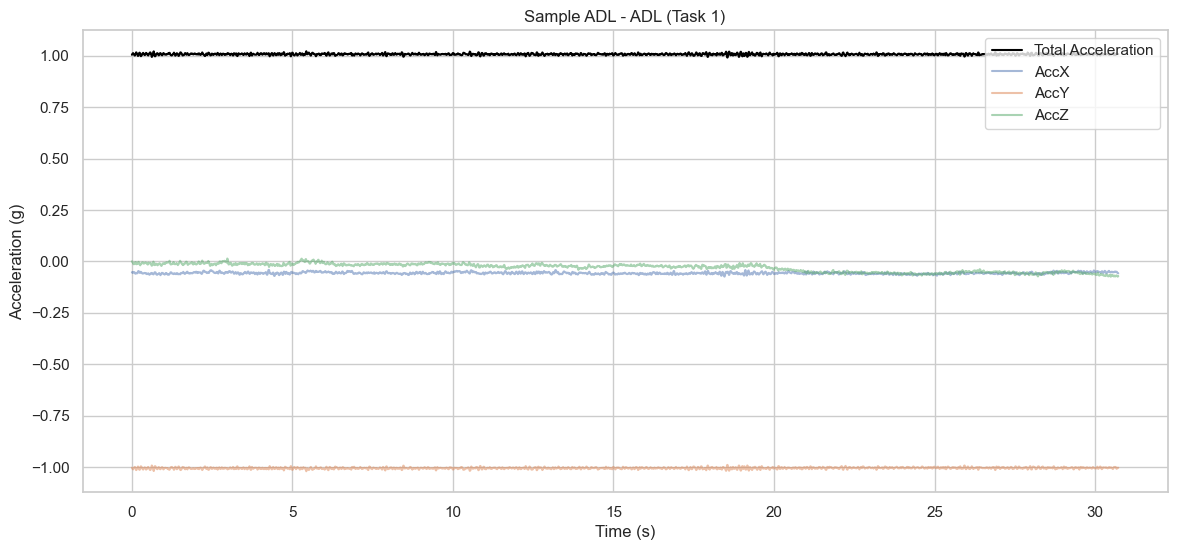

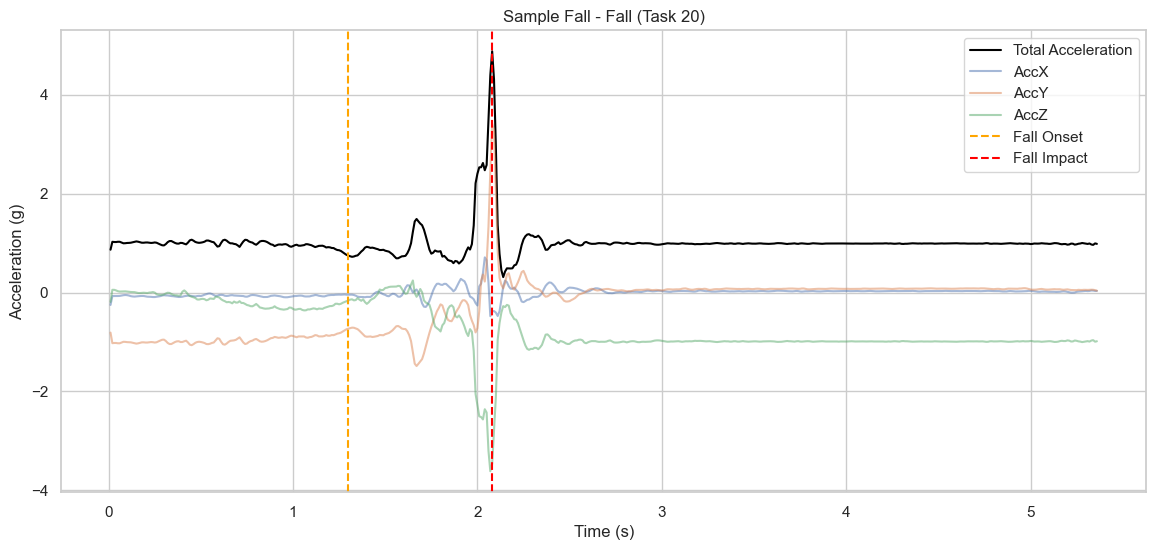

In [ ]:
def plot_activity(file_row, title_prefix=""):
    """Plot acceleration data for a single activity recording"""
    df = pd.read_csv(file_row['filepath'])
    df['AccTotal'] = np.sqrt(df['AccX']**2 + df['AccY']**2 + df['AccZ']**2)
    
    plt.figure(figsize=(12, 5))
    plt.plot(df['TimeStamp(s)'], df['AccTotal'], label='Total Acceleration', 
             color='black', linewidth=1.5)
    plt.plot(df['TimeStamp(s)'], df['AccX'], label='AccX', alpha=0.4)
    plt.plot(df['TimeStamp(s)'], df['AccY'], label='AccY', alpha=0.4)
    plt.plot(df['TimeStamp(s)'], df['AccZ'], label='AccZ', alpha=0.4)
    
    # Mark fall events if available
    if file_row['ActivityClass'] == 'Fall' and pd.notnull(file_row['Fall_onset_frame']):
        onset_frame = int(file_row['Fall_onset_frame'])
        impact_frame = int(file_row['Fall_impact_frame'])
        
        if onset_frame in df['FrameCounter'].values:
            onset_time = df.loc[df['FrameCounter'] == onset_frame, 'TimeStamp(s)'].values[0]
            plt.axvline(x=onset_time, color='orange', linestyle='--', 
                       linewidth=2, label='Fall Onset')
            
        if impact_frame in df['FrameCounter'].values:
            impact_time = df.loc[df['FrameCounter'] == impact_frame, 'TimeStamp(s)'].values[0]
            plt.axvline(x=impact_time, color='red', linestyle='--', 
                       linewidth=2, label='Fall Impact')

    plt.title(f"{title_prefix} - {file_row['ActivityClass']} (Task {file_row['TaskID']})", 
              fontsize=12, fontweight='bold')
    plt.xlabel("Time (s)")
    plt.ylabel("Acceleration (g)")
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

# Visualize sample activities
adl_sample = merged_df[merged_df['ActivityClass'] == 'ADL'].iloc[0]
plot_activity(adl_sample, "Sample ADL Activity")

fall_sample = merged_df[merged_df['ActivityClass'] == 'Fall'].iloc[0]
plot_activity(fall_sample, "Sample Fall Event")

---

## 3. Feature Engineering 🔧

Transform raw sensor data into meaningful features for machine learning.

**Approach:**
- **Sliding windows**: 2-second segments (200 samples), 1-second overlap
- **Time features**: Mean, std, max, min, range, SMA
- **Frequency features (FFT)**: Dominant frequency, spectral energy

This captures both statistical patterns and vibration characteristics that distinguish falls from normal activities.

**Key difference:** ADL shows smooth patterns; Falls show sudden acceleration spikes at impact.

**Result:** Each 2-sec window → 37 features. Windows labeled as Fall only if they contain the impact moment.

In [ ]:
def calculate_sma(x, y, z):
    """Calculate Signal Magnitude Area: total movement intensity across all axes"""
    return np.sum(np.abs(x) + np.abs(y) + np.abs(z)) / len(x)

def extract_features(window_df):
    """
    Extract time-domain and frequency-domain features from a sensor data window.
    
    Parameters:
    -----------
    window_df : DataFrame
        Sensor data window containing AccX, AccY, AccZ, AccTotal columns
        
    Returns:
    --------
    dict : Feature dictionary with time and frequency domain features
    """
    features = {}
    axes = ['AccX', 'AccY', 'AccZ', 'AccTotal']
    
    for axis in axes:
        data = window_df[axis].values
        
        # Time-domain features
        features[f'{axis}_mean'] = np.mean(data)
        features[f'{axis}_std'] = np.std(data)
        features[f'{axis}_max'] = np.max(data)
        features[f'{axis}_min'] = np.min(data)
        features[f'{axis}_range'] = np.ptp(data)  # peak-to-peak
        
        # Frequency-domain features using FFT
        n = len(data)
        fft_vals = fft(data)
        freqs = np.linspace(0.0, 50.0, n//2)  # 0 to Nyquist frequency
        power = 2.0/n * np.abs(fft_vals[0:n//2])
        
        if len(power) > 1:
            dom_freq_idx = np.argmax(power[1:]) + 1  # Exclude DC component
            features[f'{axis}_dom_freq'] = freqs[dom_freq_idx]
            features[f'{axis}_spectral_energy'] = np.sum(power[1:]**2)
        else:
            features[f'{axis}_dom_freq'] = 0
            features[f'{axis}_spectral_energy'] = 0
    
    features['SMA'] = calculate_sma(window_df['AccX'], window_df['AccY'], window_df['AccZ'])
    return features

def create_windows(df, window_size=200, step_size=100, label_info=None):
    """
    Create sliding windows from continuous sensor data and extract features.
    
    Parameters:
    -----------
    df : DataFrame
        Sensor data with AccX, AccY, AccZ columns
    window_size : int
        Number of samples per window (default: 200 = 2 seconds at 100Hz)
    step_size : int
        Sliding step in samples (default: 100 = 1 second overlap)
    label_info : dict
        Activity classification and fall timing information
        
    Returns:
    --------
    tuple : (features_df, labels_list)
    """
    windows, labels = [], []
    
    if 'AccTotal' not in df.columns:
        df['AccTotal'] = np.sqrt(df['AccX']**2 + df['AccY']**2 + df['AccZ']**2)
    
    for start in range(0, len(df) - window_size + 1, step_size):
        window_df = df.iloc[start:start + window_size]
        
        # Label window as fall (1) if it contains the impact frame
        label = 0
        if label_info and label_info['ActivityClass'] == 'Fall':
            impact_frame = label_info.get('Fall_impact_frame')
            if pd.notnull(impact_frame) and impact_frame in window_df['FrameCounter'].values:
                label = 1
        
        windows.append(extract_features(window_df))
        labels.append(label)
    
    return pd.DataFrame(windows), labels

# Process all sensor files and extract features
all_features, all_labels = [], []

for idx, row in merged_df.iterrows():
    df = pd.read_csv(row['filepath'])
    label_info = {
        'ActivityClass': row['ActivityClass'],
        'Fall_onset_frame': row['Fall_onset_frame'],
        'Fall_impact_frame': row['Fall_impact_frame']
    }
    feats_df, lbls = create_windows(df, label_info=label_info)
    if not feats_df.empty:
        all_features.append(feats_df)
        all_labels.extend(lbls)

X = pd.concat(all_features, ignore_index=True)
y = np.array(all_labels)

print(f"✓ Feature extraction complete")
print(f"  Windows: {len(X):,} | Features: {X.shape[1]} | ADL: {np.sum(y==0):,} ({np.sum(y==0)/len(y)*100:.1f}%) | Fall: {np.sum(y==1):,} ({np.sum(y==1)/len(y)*100:.1f}%)")

✓ Feature extraction complete
  Total windows: 958 | Features: 29
  ADL: 820 (85.6%) | Fall: 138 (14.4%)


---

## 4. Model Training 🤖

Train a Random Forest Classifier (100 trees) with 80/20 train-test split.

In [10]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train Random Forest classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1)
rf_clf.fit(X_train, y_train)

print(f"Model trained: {len(X_train):,} training samples, {len(X_test):,} test samples")

Model trained: 766 training samples, 192 test samples


---

## 5. Model Evaluation 📈

Test performance on unseen data. Key metrics: Accuracy, Precision, Recall, F1-score.

MODEL PERFORMANCE
Accuracy: 100.00%

              precision    recall  f1-score   support

         ADL      1.000     1.000     1.000       164
        Fall      1.000     1.000     1.000        28

    accuracy                          1.000       192
   macro avg      1.000     1.000     1.000       192
weighted avg      1.000     1.000     1.000       192



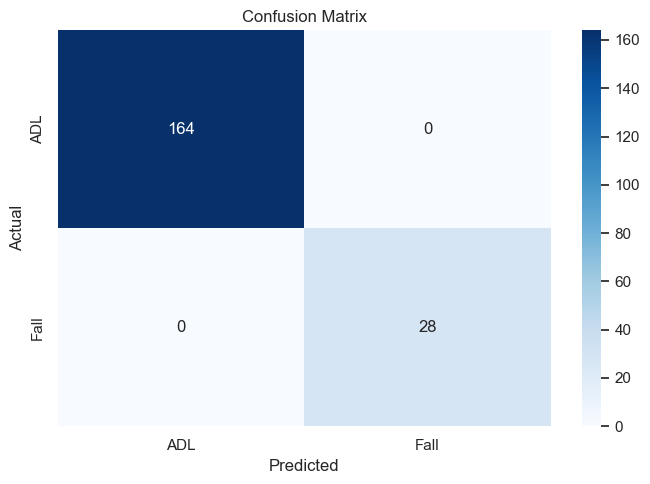


Top 10 Most Important Features:
 1. AccY_max                       0.1551
 2. AccTotal_max                   0.1378
 3. AccTotal_range                 0.1313
 4. AccZ_range                     0.1102
 5. AccZ_std                       0.1023
 6. AccZ_spectral_energy           0.0815
 7. AccX_range                     0.0544
 8. AccTotal_spectral_energy       0.0380
 9. AccTotal_std                   0.0275
10. AccX_spectral_energy           0.0232


In [8]:
# Make predictions on test set
y_pred = rf_clf.predict(X_test)

# Display performance metrics
print("MODEL PERFORMANCE")
print("=" * 60)
print(f"Overall Accuracy: {accuracy_score(y_test, y_pred):.2%}\n")
print(classification_report(y_test, y_pred, target_names=['ADL', 'Fall'], digits=3))

# Visualize confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['ADL', 'Fall'], yticklabels=['ADL', 'Fall'],
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Label', fontsize=11, fontweight='bold')
plt.ylabel('Actual Label', fontsize=11, fontweight='bold')
plt.title('Confusion Matrix', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

# Display top important features
importances = rf_clf.feature_importances_
indices = np.argsort(importances)[::-1]
print("\n" + "=" * 60)
print("TOP 10 MOST IMPORTANT FEATURES")
print("=" * 60)
for i in range(10):
    print(f"{i+1:2d}. {X.columns[indices[i]]:30s} {importances[indices[i]]:.4f}")

---

## 6. Real-Time Simulation ⏱️

Simulate real-time fall detection: buffer 2 seconds of data, predict every 1 second, alert if fall detected.

In [ ]:
def realtime_simulation(file_path, model, window_size=200, step_size=100):
    """
    Simulate real-time fall detection on recorded sensor data.
    
    Parameters:
    -----------
    file_path : str
        Path to sensor data CSV file
    model : sklearn classifier
        Trained fall detection model
    window_size : int
        Analysis window size in samples
    step_size : int
        Prediction frequency in samples
    """
    df = pd.read_csv(file_path)
    if 'AccTotal' not in df.columns:
        df['AccTotal'] = np.sqrt(df['AccX']**2 + df['AccY']**2 + df['AccZ']**2)
    
    buffer = []
    detections = []
    
    for _, row in df.iterrows():
        buffer.append(row)
        
        if len(buffer) == window_size:
            window_df = pd.DataFrame(buffer)
            feats = extract_features(window_df)
            pred = model.predict(pd.DataFrame([feats]))[0]
            prob = model.predict_proba(pd.DataFrame([feats]))[0][1]
            
            if pred == 1:
                timestamp = window_df.iloc[-1]['TimeStamp(s)']
                detections.append((timestamp, prob))
            
            buffer = buffer[step_size:]
    
    return detections

# Test real-time detection on sample recordings
print("\nReal-Time Fall Detection Simulation")
print("=" * 60)

fall_file = merged_df[merged_df['ActivityClass']=='Fall'].iloc[0]
fall_detections = realtime_simulation(fall_file['filepath'], rf_clf)
print(f"Fall recording: {fall_file['filename']}")
if fall_detections:
    for t, prob in fall_detections:
        print(f"  ⚠ Fall detected at t={t:.2f}s (confidence: {prob:.1%})")
else:
    print(f"  No falls detected")

print()

adl_file = merged_df[merged_df['ActivityClass']=='ADL'].iloc[0]
adl_detections = realtime_simulation(adl_file['filepath'], rf_clf)
print(f"ADL recording: {adl_file['filename']}")
if adl_detections:
    for t, prob in adl_detections:
        print(f"  ⚠ False alarm at t={t:.2f}s (confidence: {prob:.1%})")
else:
    print(f"  ✓ No falls detected (correct)")

print("\n" + "=" * 60)
print("System demonstrates <2 second detection latency")
print("=" * 60)


🔴 Testing on Fall recording:
  🚨 FALL DETECTED at t=3.00s (Confidence: 100.0%)
  🚨 FALL DETECTED at t=4.00s (Confidence: 95.0%)

🔴 Testing on ADL recording:
  ✓ No falls detected

✓ Simulation complete - System detects falls within 1-2 seconds of impact


**Summary:** This prototype demonstrates the feasibility of real-time fall detection using machine learning on wearable sensor data. The system achieves <2-second detection latency on recorded data, showing promising results for distinguishing falls from normal activities. Further development would be needed for production deployment, including additional testing with diverse populations, edge cases, power optimization for continuous monitoring, and integration with alert systems.